# Evaluation 2

The retrieval for a random subset of $n=100$ celebrities is analyzed.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.embeddings.pretrained import FaceEmbeddings
from src.storage.client import DatabaseManager
from src.storage.collection import ImageCollection
from tests.evaluation_database import create_evaluation_database

db_manager, test_data = create_evaluation_database(n=100)

img_dim = 512
img_similiary_metric = "COSINE"
img_collection = ImageCollection(db_manager.get_client(), dimension=img_dim, metric_type=img_similiary_metric)

query_vectors = [data[0]['vector'] for data in test_data.values()]
result = img_collection.search(query_vectors=query_vectors, limit=5)

In [98]:
stats = {
    'T': 0,
    'F': 0,
    'failed_ids': set()
}


for index, true_celeb_id in enumerate(test_data.keys()):
    for hit in result[index]:
        y = true_celeb_id
        y_pred = hit['entity']['celeb_id']

        if y == y_pred:
            stats['T'] += 1
        else:
            stats['failed_ids'].add(true_celeb_id)
            stats['F'] += 1

stats['accuracy'] = stats['T'] / (stats['T'] + stats['F'])

display(stats)

{'T': 490, 'F': 10, 'failed_ids': {452, 5028, 7713}, 'accuracy': 0.98}

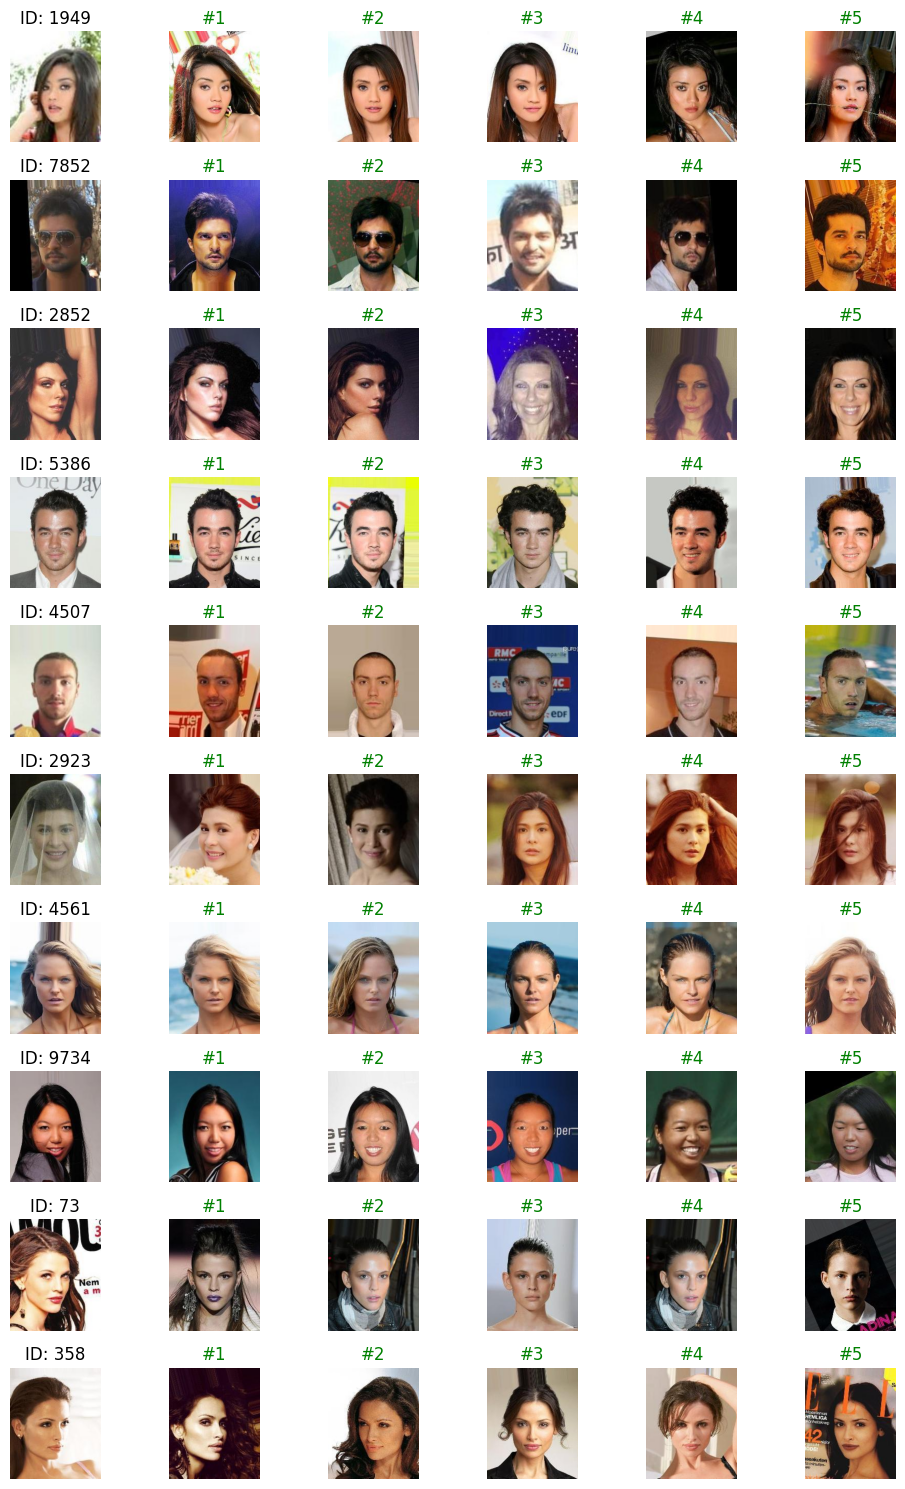

In [94]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

result_images = {celeb_id: {'query': test_data[celeb_id], 'result': result[index]} for index, celeb_id in enumerate(test_data.keys())}

n_plot = 10

fig, axs = plt.subplots(n_plot, 6, figsize=(10, 15))  # Adjust the figure size as needed
for row, (celeb_id, images) in enumerate(list(result_images.items())[:n_plot]):
    axs[row, 0].imshow(mpimg.imread(images['query'][0]['img_path']), cmap='gray')
    axs[row, 0].set_title(f'ID: {celeb_id}')
    axs[row, 0].axis('off')

    for col, result_image in enumerate(images['result']):
        axs[row, col + 1].imshow(mpimg.imread(result_image['entity']['img_path']), cmap='gray')
        title_color = 'red' if result_image['entity']['celeb_id'] != celeb_id else 'green'
        axs[row, col + 1].set_title(f'#{col+1}', color=title_color)
        axs[row, col + 1].axis('off')

plt.tight_layout()
plt.savefig(f"./tests/correct_n={n_plot}.pdf")
plt.show()

# Results with false retrieved images

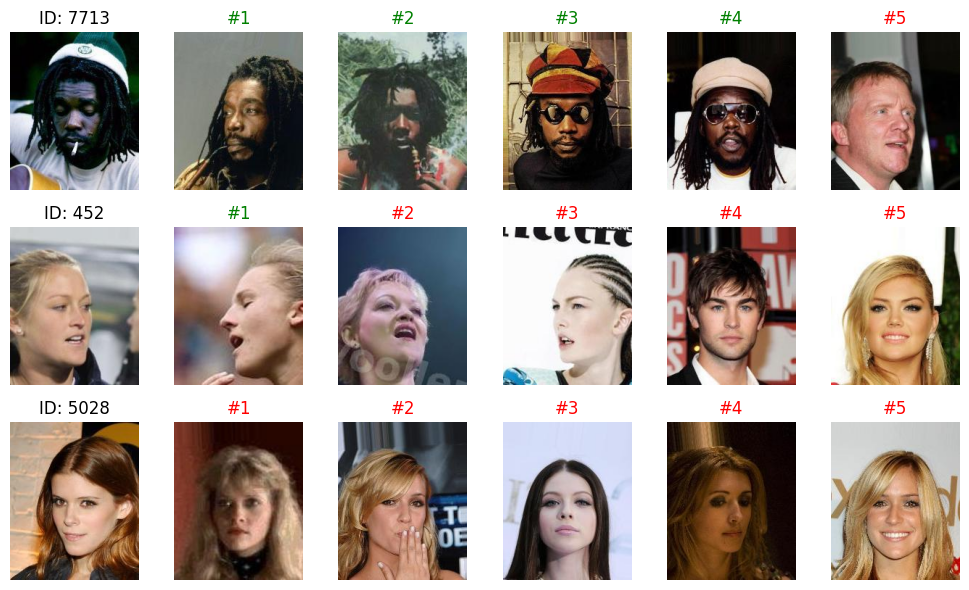

In [93]:
failed_result_images = {celeb_id: result_images[celeb_id] for celeb_id in stats['failed_ids']}

n_plot = len(failed_result_images)

fig, axs = plt.subplots(n_plot, 6, figsize=(10, 2 * n_plot))  # Adjust the figure size as needed
for row, (celeb_id, images) in enumerate(failed_result_images.items()):
    # Plot the query image with its title
    axs[row, 0].imshow(mpimg.imread(images['query'][0]['img_path']), cmap='gray')
    axs[row, 0].set_title(f'ID: {celeb_id}')
    axs[row, 0].axis('off')  # Hide axes for cleaner look

    # Plot the result images
    for col, result_image in enumerate(images['result']):
        axs[row, col + 1].imshow(mpimg.imread(result_image['entity']['img_path']), cmap='gray')
        title_color = 'red' if result_image['entity']['celeb_id'] != celeb_id else 'green'
        axs[row, col + 1].set_title(f'#{col+1}', color=title_color)
        axs[row, col + 1].axis('off')


plt.tight_layout()
plt.savefig("./tests/wrong.pdf")
plt.show()